## Import relevant packages

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

### Downloading the dataset from Tensorflow

In [2]:
hoh_dataset, hoh_info = tfds.load(name='horses_or_humans', with_info=True, as_supervised=True)

### Preprocessing the dataset

In [3]:
hoh_train, hoh_test = hoh_dataset['train'], hoh_dataset['test']

num_validation_samples = 0.1 * hoh_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

num_test_samples = hoh_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

# normally, we would like to scale our data in some way to make the result more numerically stable
# in this case we will simply prefer to have inputs between 0 and 1
# let's define a function called: scale, that will take an Horses_or_humans image and its label
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.
    return image, label

scaled_train_and_validation_data = hoh_train.map(scale)

test_data = hoh_test.map(scale)

In [4]:
BUFFER_SIZE = 10000

shuffled_train_and_validation_data = scaled_train_and_validation_data.shuffle(BUFFER_SIZE)

validation_data = shuffled_train_and_validation_data.take(num_validation_samples)
train_data = shuffled_train_and_validation_data.skip(num_validation_samples)

BATCH_SIZE = 100

# we can also take advantage of the occasion to batch the train data
# this would be very helpful when we train, as we would be able to iterate over the different batches
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples)

test_data = test_data.batch(num_test_samples)

validation_inputs, validation_targets = next(iter(validation_data))

In [5]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

NUM_EPOCHS = 15

history = model.fit(train_data,
          epochs = NUM_EPOCHS,
          callbacks=[early_stopping],
          validation_data=(validation_inputs, validation_targets),
          validation_steps=8,
          verbose=1)

Epoch 1/15
10/10 [==============================] - 16s 2s/step - loss: 0.6436 - accuracy: 0.6086 - val_loss: 0.4280 - val_accuracy: 0.8529
Epoch 2/15
10/10 [==============================] - 16s 2s/step - loss: 0.2390 - accuracy: 0.9027 - val_loss: 0.0562 - val_accuracy: 0.9804
Epoch 3/15
10/10 [==============================] - 17s 2s/step - loss: 0.1159 - accuracy: 0.9568 - val_loss: 0.4547 - val_accuracy: 0.8627
Epoch 4/15
10/10 [==============================] - 17s 2s/step - loss: 0.1686 - accuracy: 0.9286 - val_loss: 0.0553 - val_accuracy: 0.9706
Epoch 5/15
10/10 [==============================] - 16s 2s/step - loss: 0.0771 - accuracy: 0.9708 - val_loss: 0.0621 - val_accuracy: 0.9902
Epoch 6/15
10/10 [==============================] - 16s 2s/step - loss: 0.0427 - accuracy: 0.9849 - val_loss: 0.0194 - val_accuracy: 0.9902
Epoch 7/15
10/10 [==============================] - 16s 2s/step - loss: 0.0313 - accuracy: 0.9870 - val_loss: 0.0108 - val_accuracy: 0.9902
Epoch 8/15
10/10 [==

## Testing the model

In [9]:
test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 0s 5ms/step - loss: 0.9055 - accuracy: 0.9023


In [10]:
print('Test Loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100))

Test Loss: 0.91. Test accuracy: 90.23%


As you can see even with a very well trained model, the testing accuracy is still very less compared to it. This can be improved with a combination of different activation fucntions.

We can also use a bigger dataset to try and train the model, but the results still might end up being the same.

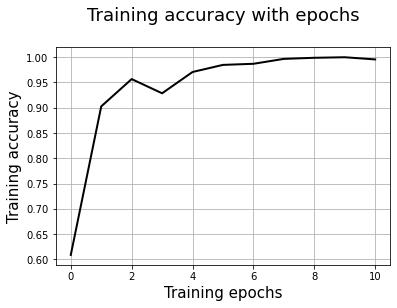

In [11]:
plt.plot(history.history['accuracy'],c='k',lw=2)
plt.grid(True)
plt.title("Training accuracy with epochs\n",fontsize=18)
plt.xlabel("Training epochs",fontsize=15)
plt.ylabel("Training accuracy",fontsize=15)
plt.show()